In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sharppy.plot.skew as skew
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from sharppy.io.spc_decoder import SPCDecoder
import xarray as xr
from metpy.calc import dewpoint_from_relative_humidity
import glob
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator
import pyart
import cartopy.crs as ccrs
import warnings; warnings.simplefilter("ignore")
import zipfile
from IPython.display import display, Markdown
import netCDF4 as nc
from sklearn.cluster import KMeans as kmeans
import seaborn as sns
import tqdm


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def plot_sounding(time, lat, lon, plot=False):

    str_fmt = "/g/data/rt52/era5/pressure-levels/reanalysis/%s/%d/%s_era5_oper_pl_%s*.nc" 
    str_fmt_sfc = "/g/data/rt52/era5/single-levels/reanalysis/%s/%d/%s_era5_oper_sfc_%s*.nc"
    
    _, latlon = get_point_data(time,lat,lon,50,["mu_cape"],plot=False,vmin=None,vmax=None)
    lat = latlon[0]
    lon = latlon[1]
    
    z=xr.open_dataset(glob.glob(str_fmt % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    t=xr.open_dataset(glob.glob(str_fmt % ("t",time.year,"t",time.strftime("%Y%m01")))[0])["t"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    r=xr.open_dataset(glob.glob(str_fmt % ("r",time.year,"r",time.strftime("%Y%m01")))[0])["r"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    u=xr.open_dataset(glob.glob(str_fmt % ("u",time.year,"u",time.strftime("%Y%m01")))[0])["u"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    v=xr.open_dataset(glob.glob(str_fmt % ("v",time.year,"v",time.strftime("%Y%m01")))[0])["v"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")

    ts=xr.open_dataset(glob.glob(str_fmt_sfc % ("2t",time.year,"2t",time.strftime("%Y%m01")))[0])["t2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    dps=xr.open_dataset(glob.glob(str_fmt_sfc % ("2d",time.year,"2d",time.strftime("%Y%m01")))[0])["d2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    us=xr.open_dataset(glob.glob(str_fmt_sfc % ("10u",time.year,"10u",time.strftime("%Y%m01")))[0])["u10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    vs=xr.open_dataset(glob.glob(str_fmt_sfc % ("10v",time.year,"10v",time.strftime("%Y%m01")))[0])["v10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    ps=xr.open_dataset(glob.glob(str_fmt_sfc % ("sp",time.year,"sp",time.strftime("%Y%m01")))[0])["sp"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    zs=xr.open_dataset(glob.glob(str_fmt_sfc % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")   
    
    p=z.level
    dp=dewpoint_from_relative_humidity(t,r)
    prof_pres = np.flip(p.values.squeeze())
    prof_hgt = np.flip(z.values.squeeze()/9.8)
    prof_tmpc = np.flip(t.values.squeeze()-273.15)
    prof_dwpc = np.flip(np.array(dp).squeeze())
    prof_u = np.flip(u.values.squeeze()*1.94)
    prof_v = np.flip(v.values.squeeze()*1.94)
    agl_inds = prof_pres <= (ps.values/100.)
    prof = profile.create_profile(pres=np.insert(prof_pres[agl_inds], 0, ps.values/100.),
                                  hght=np.insert(prof_hgt[agl_inds], 0, zs.values/9.8),
                                  tmpc=np.insert(prof_tmpc[agl_inds], 0, ts.values-273.15),
                                  dwpc=np.insert(prof_dwpc[agl_inds], 0, dps.values-273.15),
                                  u=np.insert(prof_u[agl_inds], 0, us.values*1.94),
                                  v=np.insert(prof_v[agl_inds], 0, vs.values*1.94))
    sfcpcl = params.parcelx( prof, flag=1 )
    mupcl = params.parcelx( prof, flag=3 )
    mlpcl = params.parcelx( prof, flag=4 )    
    if plot:
        # Bounds of the pressure axis 
        plt.figure()
        pb_plot=1050
        pt_plot=100
        dp_plot=10
        plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)
        # Open up the text file with the data in columns (e.g. the sample OAX file distributed with SHARPpy)
        title = time.replace(minute=0).strftime('%Y%m%d/%H%M') + ' UTC   Latitude: ' + str(lat) + ', Longitude: ' + str(lon) + '   (ERA5)'

        # Set up the figure in matplotlib.
        gs = gridspec.GridSpec(4,6, width_ratios=[1,5,1,1,1,1])
        ax = plt.subplot(gs[0:3, 0:2], projection='skewx')
        skew.draw_title(ax, title)
        ax.grid(True)
        plt.grid(True)

        # Plot the background variables
        presvals = np.arange(1000, 0, -10)
        ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
        ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)

        # Plot the parcel trace, but this may fail.  If it does so, inform the user.
        ax.semilogy(sfcpcl.ttrace, sfcpcl.ptrace, 'k:')
        ax.semilogy(mlpcl.ttrace, mlpcl.ptrace, color='tab:blue', ls=":")
        ax.semilogy(mupcl.ttrace, mupcl.ptrace, color='tab:red', ls=":")

        # Disables the log-formatting that comes with semilogy
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(np.linspace(100,1000,10))
        ax.set_ylim(1050,100)
        [ax.text(-0.3, p, str(round(h/1000,1)) + " km", transform=ax.get_yaxis_transform(), va="center") 
             for h, p in zip(prof.hght[prof.pres >= 100][3:-1:2], prof.pres[prof.pres >= 100][3:-1:2])]

        # Plot the hodograph data.
        inset_axes = skew.draw_hodo_inset(ax, prof)
        skew.plotHodo(inset_axes, prof.hght, prof.u, prof.v, color='r')

        # Draw the wind barbs axis and everything that comes with it.
        ax.set_xlim(-40,50)
        ax.set_xticks(np.arange(-40,60,10))
        ax2 = plt.subplot(gs[0:3,2])
        skew.plot_wind_axes(ax2)
        skew.plot_wind_barbs(ax2, prof.pres, prof.u, prof.v)
        srwind = params.bunkers_storm_motion(prof)
        gs.update(left=0.05, bottom=0.05, top=0.95, right=1, wspace=0.025)    

        ax3 = plt.subplot(gs[0:3,4:6])
        ax3.semilogy(prof.thetae[(~prof.thetae.mask) & (prof.pres >= 300)], prof.pres[(~prof.thetae.mask) & (prof.pres >= 300)], 'tab:blue', lw=2, ls="--")
        ax3.yaxis.set_major_formatter(ScalarFormatter())
        ax3.set_yticks(np.linspace(100,1000,10))
        ax3.set_ylim(1050,100)        

        sfc = prof.pres[prof.sfc]
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        s06 = utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1] * 0.514444
        print("MUCAPE: ",mupcl.bplus, "MLCAPE: ",mlpcl.bplus, "SBCAPE: ",sfcpcl.bplus, "S06: ",s06, "DCAPE",params.dcape(prof)[0])

    return prof, mupcl
        
def get_point_data(time,lat,lon,r,var,plot=False,vmin=None,vmax=None):
    
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var+["mu_cape"]].sel({"time":time.replace(minute=0)})
    
    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    mask = get_mask(lons,lats)
    a,b = np.where( (dist_km <= r) & (mask == 1) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(lon=target_lons, lat=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r) & (mask == 1), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    #Return the value of the point with the highest absolute value
    #print(f_slice)
    return pd.DataFrame([f_slice[v].values[np.abs(f_slice[v]).argmax()] for v in var], index=var),\
            [f_slice.lat.values[np.abs(f_slice["mu_cape"]).argmax()],\
             f_slice.lon.values[np.abs(f_slice["mu_cape"]).argmax()] ]

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]

def plot_prof(prof, ax, ax2, gs):
        pb_plot=1050
        pt_plot=100
        dp_plot=10
        plevs_plot = np.arange(pb_plot,pt_plot-1,-dp_plot)
        # Open up the text file with the data in columns (e.g. the sample OAX file distributed with SHARPpy)

        # Set up the figure in matplotlib.
        ax.grid(True)
        plt.grid(True)

        # Plot the background variables
        presvals = np.arange(1000, 0, -10)
        ax.semilogy(prof.tmpc[~prof.tmpc.mask], prof.pres[~prof.tmpc.mask], 'r', lw=2)
        ax.semilogy(prof.dwpc[~prof.dwpc.mask], prof.pres[~prof.dwpc.mask], 'g', lw=2)

        # Plot the parcel trace, but this may fail.  If it does so, inform the user.
        sfcpcl = params.parcelx( prof, flag=1 )
        mupcl = params.parcelx( prof, flag=3 )
        mlpcl = params.parcelx( prof, flag=4 )
        ax.semilogy(sfcpcl.ttrace, sfcpcl.ptrace, 'k:')
        ax.semilogy(mlpcl.ttrace, mlpcl.ptrace, color='tab:blue', ls=":")
        ax.semilogy(mupcl.ttrace, mupcl.ptrace, color='tab:red', ls=":")

        # Disables the log-formatting that comes with semilogy
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(np.linspace(100,1000,10))
        ax.set_ylim(1050,100)
        [ax.text(-0.4, p, str(round(h/1000,1)) + " km", transform=ax.get_yaxis_transform(), va="center") 
             for h, p in zip(prof.hght[prof.pres >= 100][3:-1:2], prof.pres[prof.pres >= 100][3:-1:2])]

        # Plot the hodograph data.
        inset_axes = skew.draw_hodo_inset(ax, prof)
        skew.plotHodo(inset_axes, prof.hght, (prof.u), (prof.v), color='r')
        inset_axes.set_xlim([-50,60])
        inset_axes.set_ylim([-50,60])

        # Draw the wind barbs axis and everything that comes with it.
        ax.set_xlim(-40,50)
        ax.set_xticks(np.arange(-40,60,10))
        skew.plot_wind_axes(ax2)
        skew.plot_wind_barbs(ax2, prof.pres, prof.u, prof.v)
        srwind = params.bunkers_storm_motion(prof)
        gs.update(left=0.05, bottom=0.05, top=0.95, right=1, wspace=0.025)       

        sfc = prof.pres[prof.sfc]
        p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
        sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
        s06 = utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1] * 0.514444
        print("MUCAPE: ",mupcl.bplus, "MLCAPE: ",mlpcl.bplus, "SBCAPE: ",sfcpcl.bplus, "S06: ",s06, "DCAPE",params.dcape(prof)[0])

def rotate_wind(prof, p_int):
    
    #From a profile (of u and v winds), rotate the wind profile so that Umean06 is westerly.
    
    u = interp.components(prof,p_int)[0].filled(np.nan)
    v = interp.components(prof,p_int)[1].filled(np.nan)

    x2,y2 = [1,0]
    x1,y1 = winds.mean_wind(prof,pbot=prof.pres.max(),ptop=interp.pres(prof,6000))
    
    angle = np.arctan2(x1*y2-y1*x2,x1*x2+y1*y2)

    u_prime = u*np.cos(angle) - v*np.sin(angle)
    v_prime = u*np.sin(angle) + v*np.cos(angle)

    ub = x2 / (np.sqrt(x2**2 + y2**2)) *1
    vb = y2 / (np.sqrt(x2**2 + y2**2)) *1    
    
    return u_prime, v_prime

In [3]:
details_list = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"Melbourne", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"Melbourne", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"Melbourne", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"Melbourne", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"Melbourne", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"Melbourne", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"Melbourne", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"Melbourne", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"Melbourne", "title":"i) Melbourne:  UTC"},\
       \
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"Sydney", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"Sydney", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"Sydney", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"Sydney", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"Sydney", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"Sydney", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"Sydney", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"Sydney", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"Sydney", "title":"i) Sydney: UTC"},\
       \
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"Amberley", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"Amberley", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"Amberley", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"Amberley", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"Amberley", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"Amberley", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"Amberley", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"Amberley", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"Amberley", "title":"i) Oakey: UTC"},\
       \
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"Woomera", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"Woomera", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"Woomera", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"Woomera", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"Woomera", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"Woomera", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"Woomera", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"Woomera", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"Woomera", "title":"i) "},\
         ]

profs = []
mupcls = []
for details in tqdm.tqdm(details_list):
    prof, mu_pcl = plot_sounding(details["time"][0],details["lat"],details["lon"], plot=False)
    profs.append(prof)
    mupcls.append(mu_pcl)

100%|██████████| 36/36 [03:54<00:00,  6.50s/it]


In [4]:
var=["s06","qmean01","lr13","Umean06"]

df = pd.DataFrame()
for details in tqdm.tqdm(details_list):
    df = pd.concat([df, 
       get_point_data(details["time"][0], details["lat"], details["lon"], 50, var+["dcape"], plot=False)[0].T],
                  axis=0)

df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
mod=kmeans(n_clusters=3, verbose=0, random_state=0)
mod_fit=mod.fit(df_norm[var])
cluster_index = mod_fit.predict(df_norm[var])

100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


MUCAPE:  15.647293971181917 MLCAPE:  0.0 SBCAPE:  15.647293971181917 S06:  15.394595043678194 DCAPE 140.30111800870708
MUCAPE:  937.4546917836725 MLCAPE:  133.91343349187704 SBCAPE:  937.4546917836725 S06:  23.40126651126144 DCAPE 1089.3597492761364
MUCAPE:  1555.0474862023411 MLCAPE:  1175.9963326008965 SBCAPE:  1555.0474862023411 S06:  13.68340049905898 DCAPE 911.5310603042628


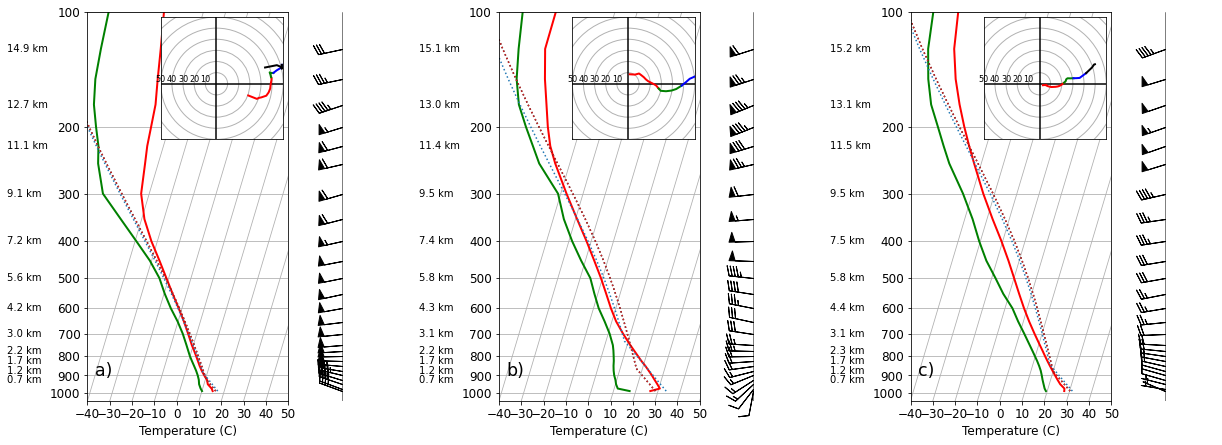

In [20]:
p_int = [990,  975,  950,  925,  900,  875,  850,  825,  800,  775,  750,
        700,  650,  600,  550,  500,  450,  400,  350,  300,  250,  225,
        200,  175,  150,  125,  100,   70,   50,   30,   20,   10,    7,
          5,    3,    2,    1]

plt.figure(figsize=[18,6])
plt.rcParams.update({'xtick.labelsize': 'large', 'ytick.labelsize': 'large'})
gs = gridspec.GridSpec(1,9, width_ratios=[2,1,1,2,1,1,2,1,1])
letter = ["a)", "b)", "c)"]
cnt=0
for i in [0,2,1]:
    tmpc = np.nanmean(np.stack([interp.temp(p,p_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    pres = p_int
    hght = np.nanmean(np.stack([interp.hght(p,p_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    dwpc = np.nanmean(np.stack([interp.dwpt(p,p_int).filled(np.nan) for p in np.array(profs)[cluster_index==i]]), axis=0)
    u = np.nanmean(np.stack([rotate_wind(p,p_int)[0] for p in np.array(profs)[cluster_index==i]]), axis=0)
    v = np.nanmean(np.stack([rotate_wind(p,p_int)[1] for p in np.array(profs)[cluster_index==i]]), axis=0)    
    prof = profile.create_profile(tmpc=tmpc, pres=pres, hght=hght, dwpc=dwpc, u=u, v=v, missing=np.nan)

    ax = plt.subplot(gs[0, 3*cnt], projection='skewx')
    ax2 = plt.subplot(gs[0, (3*cnt)+1])
    plot_prof(prof, ax, ax2, gs)
    ax.set_xlabel("Temperature (C)",size=12)
    ax.text(-40, 900, letter[cnt], fontsize="xx-large")
    cnt=cnt+1

#Hodograph legend
#Red: 0-3 km
#Green: 3-6 km
#Blue: 6-9 km
#Black: 9-12 km
plt.subplots_adjust(bottom=0.4)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/sounding_composites.jpeg", quality=100, bbox_inches="tight")